In [4]:
# Geo Scripting Exercise 12
# Alejandro Salazar & Bob Souwer
# 24-01-2017

# import modules
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly, GDT_Float32
import numpy as np
import os

## This script only works if the landsat images are downloaded, unpacked and placed in the data folder

# list files in data folder and open the ones needed
filenames = next(os.walk("data/"))[2]

band4 = gdal.Open('data/' + filenames[-1], GA_ReadOnly)
band5 = gdal.Open('data/' + filenames[-2], GA_ReadOnly)

# Function to derive NDWI from selected bands
def derive_ndwi(band4, band5):
    # Read data into an Numpy Array
    band4Arr = band4.ReadAsArray(0,0,band4.RasterXSize, band4.RasterYSize)
    band5Arr = band5.ReadAsArray(0,0,band5.RasterXSize, band5.RasterYSize)
    # set the data type
    band4Arr=band4Arr.astype(np.float32)
    band5Arr=band5Arr.astype(np.float32)
    mask = np.greater(band4Arr+band5Arr,0)
    ## derive NDWI
    # mask to filter out negative values
    with np.errstate(invalid='ignore'):
        ndwi = np.choose(mask,(-99,(band4Arr-band5Arr)/(band4Arr+band5Arr)))
    # Write the result to disk
    driver = gdal.GetDriverByName('GTiff')
    outDataSet=driver.Create('data/ndwi.tif', band4.RasterXSize, band4.RasterYSize, 1, GDT_Float32)
    outBand = outDataSet.GetRasterBand(1)
    outBand.WriteArray(ndwi,0,0)
    outBand.SetNoDataValue(-99)
    # set the projection and extent information of the dataset
    outDataSet.SetProjection(band4.GetProjection())
    outDataSet.SetGeoTransform(band4.GetGeoTransform())
    # Finally let's save it... or like in the OGR example flush it
    outBand.FlushCache()
    outDataSet.FlushCache()
    # Use GDAL Warp function to reproject to Lat/Long WGS84
    !gdalwarp -t_srs "EPSG:4326" data/ndwi.tif data/ndwi_ll.tif

# call the function
derive_ndwi(band4, band5)

Processing input file data/ndwi.tif.
Using internal nodata values (e.g. -99) for image data/ndwi.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
49.6667


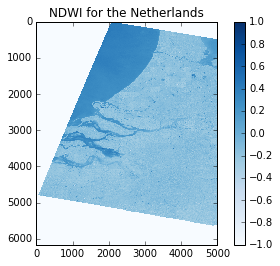

In [15]:
# Geo Scripting Exercise 12
# Alejandro Salazar & Bob Souwer
# 24-01-2017

%matplotlib inline
from osgeo import gdal
import matplotlib.pyplot as plt

# Open image
dsll = gdal.Open("data/ndwi_ll.tif")

# Read raster data
ndwi = dsll.ReadAsArray(0 ,0, dsll.RasterXSize, dsll.RasterYSize)

# Now plot the raster data using blues palette
plt.imshow(ndwi, interpolation='nearest', vmin=-1, vmax=1, cmap=plt.cm.Blues)
plt.title("NDWI for the Netherlands")
plt.colorbar()
plt.show()

dsll = None